# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
# dataDir = "C:/AV/Carla/CARLA_0.9.13/WindowsNoEditor/PythonAPI/experiments/logs"
dataDir = "../data/"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
from typing import *
import numpy as np

from scipy.ndimage import gaussian_filter1d

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
# Some utility tools
def makeUniqueId(recordingIds: Union[int, pd.Series], participantIds: Union[int, pd.Series]) -> int:
    return recordingIds * 1000000 + participantIds

def getRecordingPedIds(recordingMeta: Dict[str, any]) -> List[int]:
    pedIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "pedestrian":
            pedIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return pedIds


def getRecordingVehicleIds(recordingMeta: Dict[str, any]) -> List[int]:
    vIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "vehicle":
            vIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return vIds

def getPedToVIds(meta: Dict[int, any]) -> Dict[int, int]:
    pToV = {}
    for recordingId, recordingMeta in meta.items():
        pedIds = getRecordingPedIds(recordingMeta)
        vIds = getRecordingVehicleIds(recordingMeta)
        for pedId in pedIds:
            pToV[pedId] = vIds.copy() # just to be safe
    return pToV
            

    
    

In [6]:
# researchName = '4-lane-lc-Research1v1NavPathModel'
researchName = '2-lane-Research1v1NavPathModel'
# researchName = 'Research1v1NavPathModel'
date = "2023-09-15"
fps=25
minYDisplacement = 5
maxXDisplacement = 9

#tracks meta
with open(os.path.join(dataDir, f"{researchName}-{date}-meta.json"), "r") as f:
    metaJson = json.load(f)

meta = {}
for recordingObj in metaJson:
    meta[recordingObj['recordingId']] = recordingObj
    

# tracks
df = pd.read_csv(os.path.join(dataDir, f"{researchName}-{date}-tracks.csv"))
df["uniqueTrackId"] = makeUniqueId(df["recordingId"], df["trackId"])
pedDf = df[df["class"] == "pedestrian"].copy()
otherDf = df[df["class"] != "pedestrian"].copy()

In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='x', 
        yCol='y',
        xVelCol='xVel', 
        yVelCol='yVel', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)

In [8]:
# Pre process ped
## droping unnecessary states
pedDf = pedDf[(pedDf['state'] != "INITALIZING") & (pedDf['state'] != "FINISHED") & (pedDf['state'] != "CLIMBING_SIDEWALK")].copy()
print(pedDf.tail())
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.smoothenSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# pedDf.describe()
pedDf.head()

       recordingId  trackId       class  frame          x          y  \
60708          100     1644  pedestrian    354 -55.829937  25.721762   
60709          100     1644  pedestrian    355 -55.761013  25.680901   
60710          100     1644  pedestrian    356 -55.691597  25.641150   
60711          100     1644  pedestrian    357 -55.622356  25.599768   
60712          100     1644  pedestrian    358 -55.553555  25.558884   

         heading     state  uniqueTrackId  
60708 -28.240870  CROSSING      100001644  
60709 -32.821278  CROSSING      100001644  
60710 -28.240685  CROSSING      100001644  
60711 -32.781910  CROSSING      100001644  
60712 -28.238974  CROSSING      100001644  


,recordingId,trackId,class,frame,x,y,heading,state,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
293,1,1347,pedestrian,100,-64.462540,28.537523,-0.31543,CROSSING,1001347,-0.593758,0.00329,0.593767,0.592393,0.000000,0.000000
294,1,1347,pedestrian,101,-64.438789,28.537392,-0.31543,CROSSING,1001347,-0.593758,0.00329,0.593767,0.591859,0.023750,0.000132
295,1,1347,pedestrian,102,-64.415085,28.537260,-0.31543,CROSSING,1001347,-0.592613,0.00329,0.592622,0.591314,0.047455,0.000263
296,1,1347,pedestrian,103,-64.391426,28.537128,-0.31543,CROSSING,1001347,-0.591469,0.00329,0.591478,0.590763,0.071114,0.000395
297,1,1347,pedestrian,104,-64.367813,28.536997,-0.31543,CROSSING,1001347,-0.590324,0.00329,0.590334,0.590206,0.094727,0.000526


# Optional: Cut-off after stop

In [9]:
# frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
# pedIds = frozenPedDf["uniqueTrackId"].unique()
# pedDfs = []
# for pedId in pedIds:
#     aFrozenPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
#     lastFrozenFrame = aFrozenPed.iloc[-1]['frame']
#     aPed = pedDf[pedDf['frame'] <= lastFrozenFrame].copy()
#     aPed.reset_index(drop=True, inplace=True)
#     pedDfs.append(aPed)
# pedDf = pd.concat(pedDfs, ignore_index=True)

In [10]:
# Pre-process vehicle

transformer.deriveAxisVelocities(otherDf)
transformer.deriveSpeed(otherDf)
otherDf['speed'] = otherDf['speed'] * 3.6 # to km/h
transformer.smoothenSpeed(otherDf, targetFps=1)
transformer.deriveDisplacements(otherDf)
otherDf.describe()
# otherDf.head()

,recordingId,trackId,frame,x,y,heading,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
count,30357.000000,30357.000000,30357.000000,30357.000000,30357.000000,30357.000000,3.035700e+04,30357.000000,30357.000000,30357.000000,30357.000000,30357.000000,30357.000000
mean,50.706954,1495.120862,254.781830,-58.105478,36.748483,-89.946356,5.070845e+07,-0.000619,2.654414,9.556018,9.552432,0.038931,16.403967
std,28.497331,85.491993,93.585611,0.024144,10.324407,0.333667,2.849742e+07,0.013658,0.873787,3.145626,3.101199,0.022533,9.851753
min,1.000000,1346.000000,100.000000,-58.190571,11.719851,-95.569939,1.001346e+06,-0.487137,-0.001049,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1424.000000,175.000000,-58.124500,28.844948,-90.182549,2.700142e+07,-0.009727,2.212286,7.964292,7.962967,0.019455,8.069103
50%,51.000000,1496.000000,251.000000,-58.103020,37.066498,-89.802940,5.100150e+07,-0.006676,2.680302,9.649148,9.648891,0.039555,16.270039
75%,75.000000,1568.000000,327.000000,-58.083996,45.273460,-89.787346,7.500157e+07,0.010967,3.284168,11.823174,11.823283,0.057957,23.691296
max,100.000000,1643.000000,500.000000,-57.968254,56.341145,-88.990631,1.000016e+08,0.082970,4.055977,14.601616,14.597373,0.183376,38.014471


In [11]:
pedIds = pedDf["uniqueTrackId"].unique()

In [12]:
aPed = pedDf[pedDf["uniqueTrackId"] == pedIds[0]]
# plt.plot(aPed["yVel"], label='yVel')
# plt.plot(aPed["xVel"], label='xVel')
# plt.legend()
# sns.lineplot(aPed["speed"])
# sns.lineplot(aPed["speedSmooth"])

In [13]:
# smoothSpeed = aPed['speed'].rolling(10).mean()
# sns.lineplot(smoothSpeed, label='avg')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=1)
# sns.lineplot(smoothSpeed, label='gaussian1')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=2)
# sns.lineplot(smoothSpeed, label='gaussian2')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=3)
# sns.lineplot(smoothSpeed, label='gaussian3')

# Trajectory Stats & Visualizations

In [14]:
legend = False
limit = 10
plt.rcParams.update({'font.size': 24})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


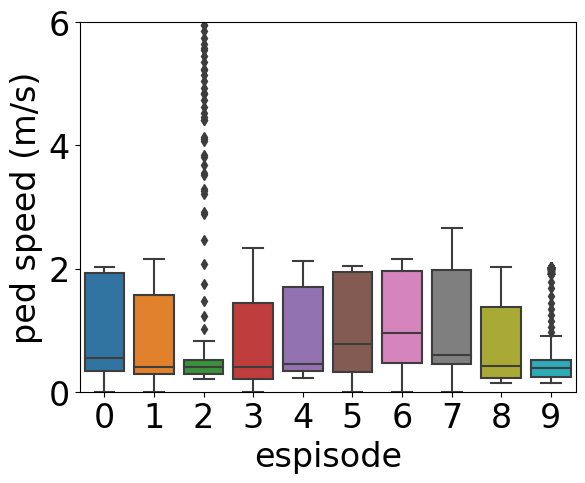

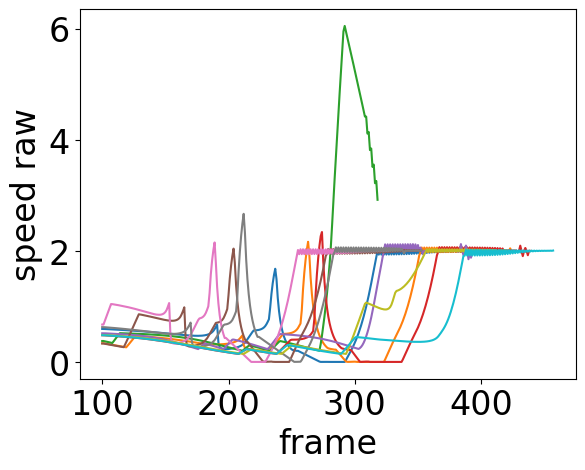

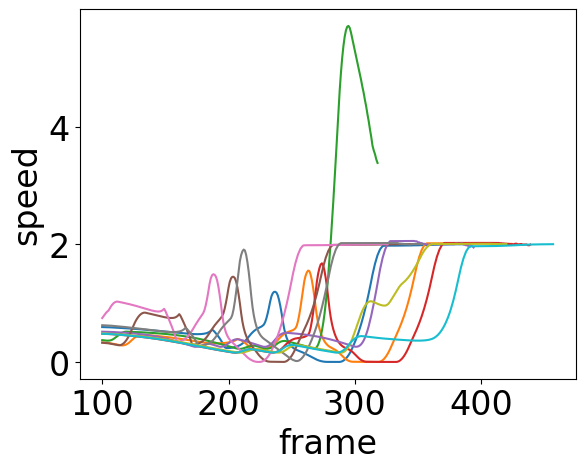

In [15]:
speedSeres = []
pedIds = pedDf["uniqueTrackId"].unique()
pedIds = pedIds[:limit]
# pedIds = np.random.choice(pedIds, limit)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    speedSeres.append(aPed["speed"])
    # print("avg speed", aPed["speed"].mean())
    # print("max speed", aPed["speed"].max())
sns.boxplot(speedSeres)
plt.ylim(0, 6)
plt.xlabel("espisode")
plt.ylabel("ped speed (m/s)")
# plt.title("Speed")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

x = range(500)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speed", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed raw")
# plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
# plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

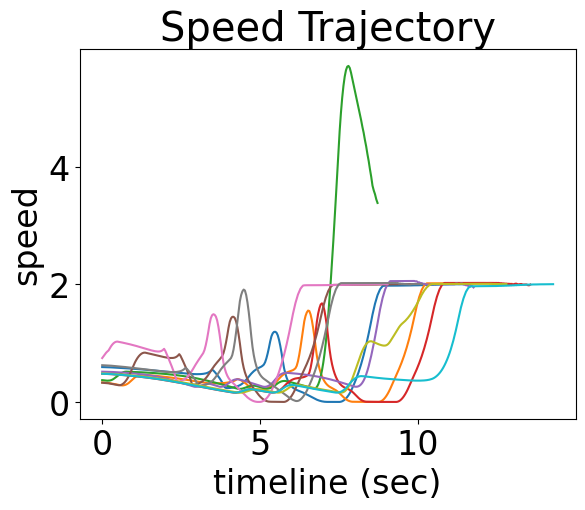

In [16]:
# visualization in seconds
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline (sec)")
plt.ylabel("speed")
plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()


# Frozen State Stats and Visualization

In [17]:
frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
pedIds = frozenPedDf["uniqueTrackId"].unique()

limit = 10
pedIds = np.random.choice(pedIds, limit)

# Number of pedestrians failed

In [18]:


print("Trajectories without stop", len(pedDf["uniqueTrackId"].unique()) - len(frozenPedDf["uniqueTrackId"].unique()))

Trajectories without stop 21


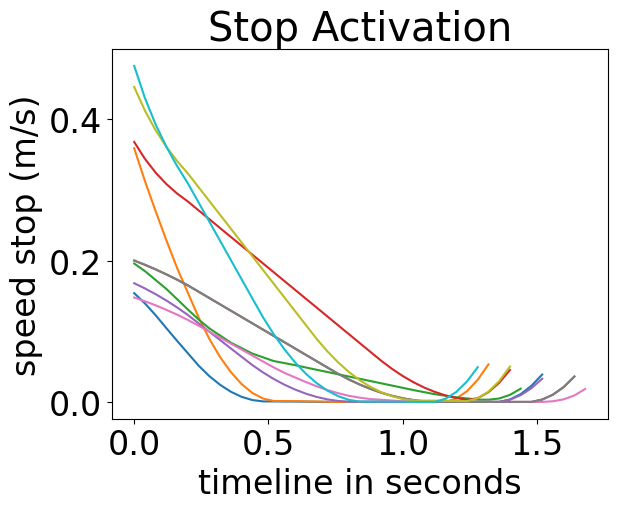

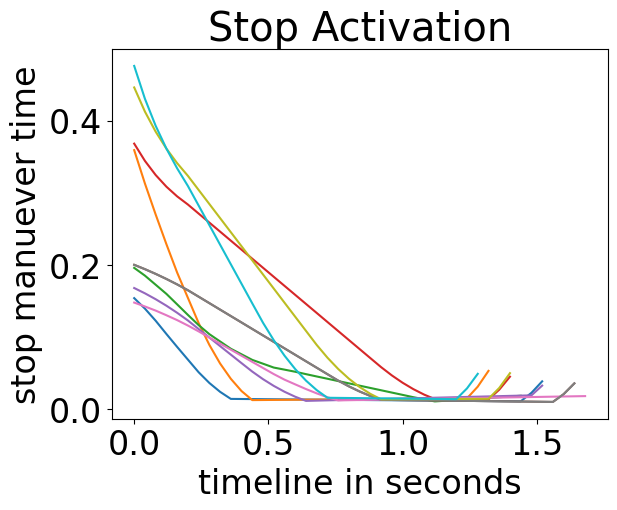

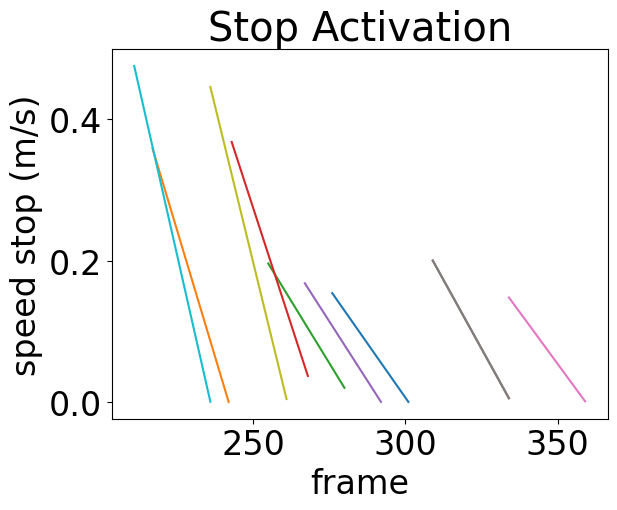

In [19]:
plt.rcParams.update({'font.size': 24})

# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("speed stop (m/s)")
plt.title("Stop Activation")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()


# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed[aPed['speedSmooth'] > 0.01]
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("stop manuever time")
plt.title("Stop Activation")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

# visualization in frames
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed stop (m/s)")
plt.title("Stop Activation")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()



# Statistics

In [20]:
from collections import defaultdict

In [21]:
# Pedestrian statistics
pedIds = pedDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    colData['uniqueTrackId'].append(pedId)
    colData['speed-avg'].append(aPed['speed'].mean())
    colData['speed-max'].append(aPed['speed'].max())
    colData['speed-min'].append(aPed['speed'].min())
    
    ## related to stop only
    
    aPedFrozen = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    if len(aPedFrozen) > 0:
        colData['stop-duration'].append(len(aPedFrozen) / fps)
        colData['stop-loc-first-frame'].append(aPedFrozen.iloc[0]['frame'])
        colData['stop-loc-first-x'].append(aPedFrozen.iloc[0]['x'])
        colData['stop-loc-first-y'].append(aPedFrozen.iloc[0]['y'])
        colData['stop-loc-last-frame'].append(aPedFrozen.iloc[-1]['frame'])
        colData['stop-loc-last-x'].append(aPedFrozen.iloc[-1]['x'])
        colData['stop-loc-last-y'].append(aPedFrozen.iloc[-1]['y'])
        
        
    else:
        colData['stop-duration'].append(None)
        colData['stop-loc-first-frame'].append(None)
        colData['stop-loc-first-x'].append(None)
        colData['stop-loc-first-y'].append(None)
        colData['stop-loc-last-frame'].append(None)
        colData['stop-loc-last-x'].append(None)
        colData['stop-loc-last-y'].append(None)

pedStats = pd.DataFrame(colData)
pedStats.dropna(inplace=True)
pedStats.head()

,uniqueTrackId,speed-avg,speed-max,speed-min,stop-duration,stop-loc-first-frame,stop-loc-first-x,stop-loc-first-y,stop-loc-last-frame,stop-loc-last-x,stop-loc-last-y
0,1001347,0.854103,2.020896,0.000000,1.52,255.0,-61.311962,28.817280,292.0,-61.256245,28.853029
1,2001350,0.771617,2.162120,0.000000,1.56,285.0,-61.393932,28.850809,323.0,-61.365135,28.863565
2,3001353,1.098873,6.047745,0.200465,0.40,309.0,-56.545330,30.768711,318.0,-55.329994,31.213234
3,4001356,0.735321,2.338303,0.000000,1.64,297.0,-61.471077,28.868486,337.0,-61.447598,28.878107
5,6001362,0.990096,2.039104,0.000000,1.36,215.0,-61.597237,28.792137,248.0,-61.524055,28.829624


In [22]:
# Vehicle statistics
vIds = otherDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for vId in vIds:
    aV = otherDf[otherDf["uniqueTrackId"] == vId]
    colData['uniqueTrackId'].append(vId)
    colData['speed-avg'].append(aV['speed'].mean())
    colData['speed-max'].append(aV['speed'].max())
    colData['speed-min'].append(aV['speed'].min())
    
    
vehicleStats = pd.DataFrame(colData)
vehicleStats.tail()

,uniqueTrackId,speed-avg,speed-max,speed-min
95,96001631,13.109116,13.110557,13.107467
96,97001634,11.931835,11.932954,11.931153
97,98001637,7.882430,8.607904,6.053858
98,99001640,14.048599,14.050910,14.044391
99,100001643,12.801350,12.802259,12.799521


In [23]:
# Correlations
# plt.rcParams.update({'font.size': 24})
# sns.pairplot(pedStats[['speed-avg', 'speed-max', 'stop-duration']], height=4)

# # plt.xlabel("Correlations")
# # plt.ylabel("speed")
# # plt.title("Correlations")
# plt.show()

# Marginal Distributions

In [24]:
plt.rcParams.update({'font.size': 24})

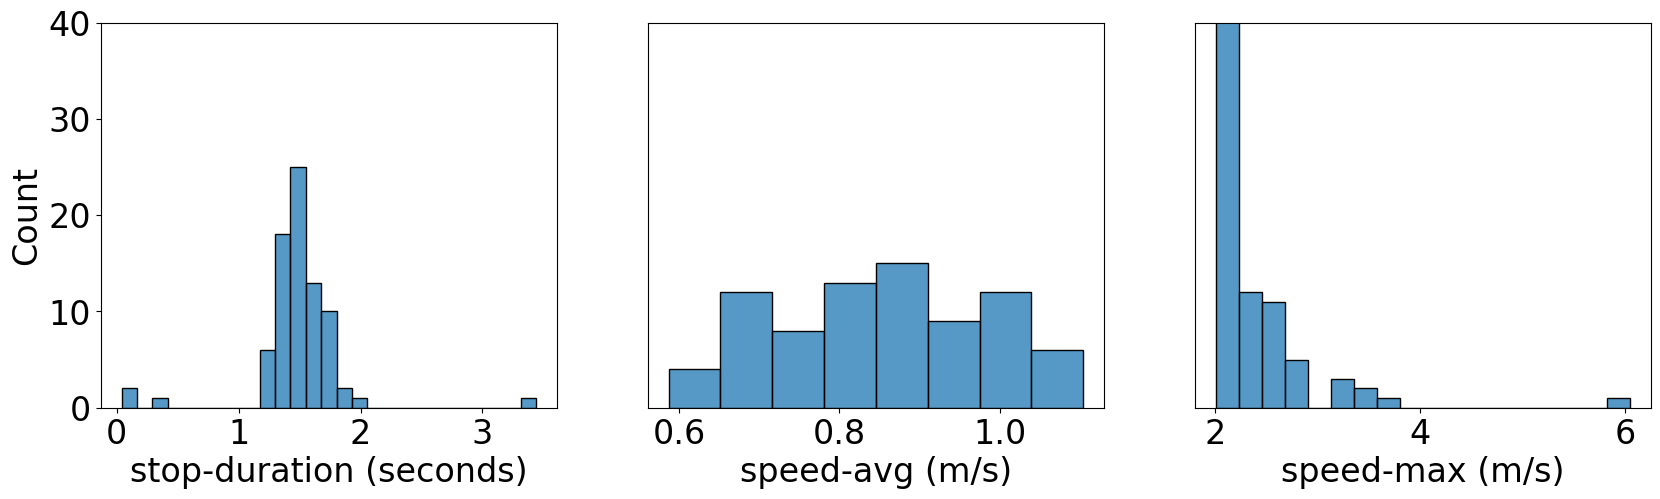

In [25]:
# Pedestrian Marginal Distributions
fig, axes = plt.subplots(1,3, figsize = (20,5))
sns.histplot(pedStats['stop-duration'] ,ax=axes[0])
axes[0].set_xlabel("stop-duration (seconds)")
axes[0].set_ylim(0, 40)

sns.histplot(pedStats['speed-avg'] ,ax=axes[1])
axes[1].set_xlabel("speed-avg (m/s)")
axes[1].set_ylim(0, 40)
axes[1].get_yaxis().set_visible(False)


sns.histplot(pedStats['speed-max'] ,ax=axes[2])
axes[2].set_xlabel("speed-max (m/s)")
axes[2].set_ylim(0, 40)
axes[2].get_yaxis().set_visible(False)



plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


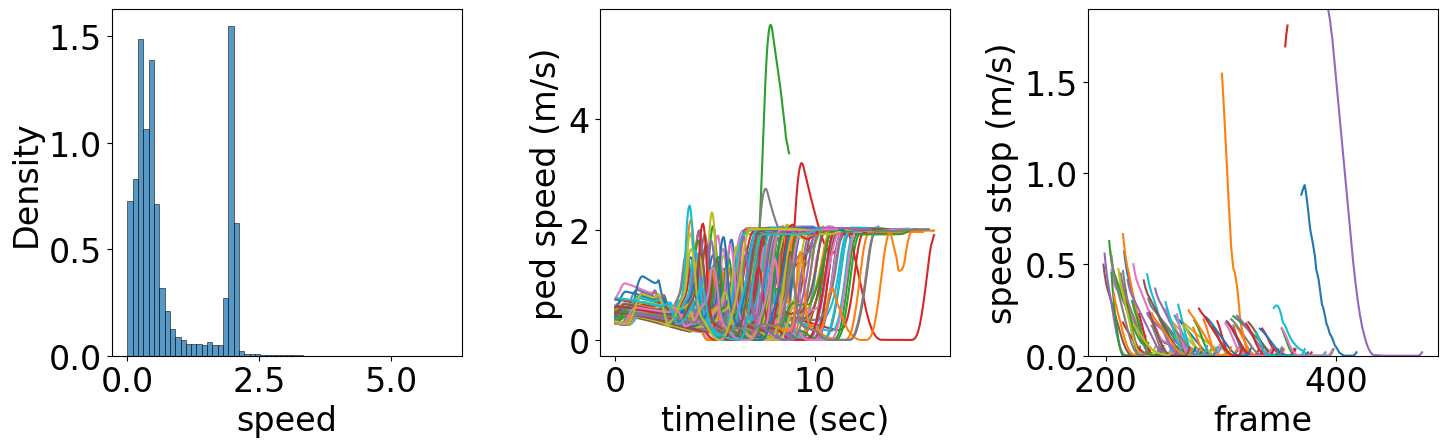

In [26]:
legend = False
fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.histplot(pedDf['speed'], stat='density',ax=axes[0])
plt.xlabel("speed (m/s)")
if not legend:
    axes[1].legend().remove()
else:
    axes[1].legend()

#trajectories
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}", ax=axes[1])
axes[1].set_xlabel("timeline (sec)")
axes[1].set_ylabel("ped speed (m/s)")
if not legend:
    axes[1].legend().remove()
else:
    axes[1].legend()

# stop activation
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}", ax=axes[2])
axes[2].set_xlabel("frame")
axes[2].set_ylabel("speed stop (m/s)")
axes[2].set_ylim(0, 1.9)
if not legend:
    axes[2].legend().remove()
else:
    axes[2].legend()

fig.tight_layout()
plt.show()

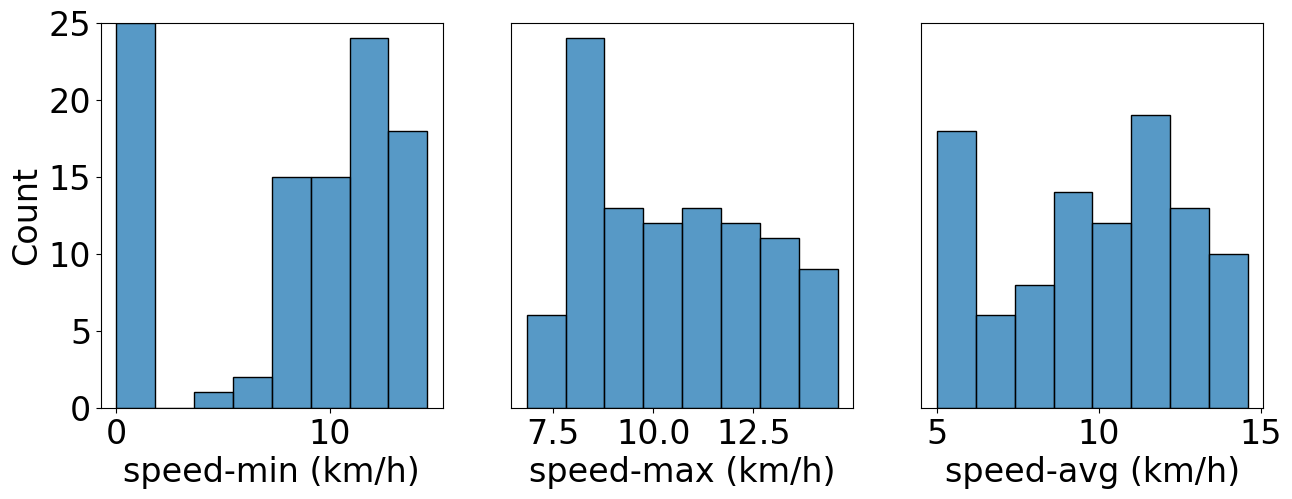

In [27]:
# Vehicle Marginal Distributions
fig, axes = plt.subplots(1, 3, figsize = (15,5))

sns.histplot(vehicleStats['speed-min'] ,ax=axes[0], label="km/h")
axes[0].set_xlabel("speed-min (km/h)")
axes[0].set_ylim(0, 25)

sns.histplot(vehicleStats['speed-max'] ,ax=axes[1])
axes[1].set_xlabel("speed-max (km/h)")
axes[1].set_ylim(0, 25)
axes[1].get_yaxis().set_visible(False)

sns.histplot(vehicleStats['speed-avg'] ,ax=axes[2])
axes[2].set_xlabel("speed-avg (km/h)")
axes[2].set_ylim(0, 25)
axes[2].get_yaxis().set_visible(False)

plt.show()

# Self joint probabilities

In [28]:
plt.rcParams.update({'font.size': 48})

In [29]:
def plotJoint(data, x, y, height=10, caxloc=[.25, .25, .02, .2], xTitle=None, yTitle=None):
    g = sns.JointGrid(data=data, x=x, y=y, height=height)
    
    # g.plot(sns.scatterplot, sns.histplot)
    cax = g.figure.add_axes(caxloc)
    # Add the joint and marginal histogram plots
    j = g.plot_joint(
        sns.histplot, discrete=(False, False),
        pmax=.8, cbar=True, cbar_ax=cax
    )
    if xTitle is None:
        xTitle = x
    if yTitle is None:
        yTitle = y
    j.set_axis_labels(xTitle, yTitle)
    # g.plot_marginals(sns.histplot, element="step", color="#03012d")
    g.plot_marginals(sns.histplot, element="step", color="#ccdddd",)
    

C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


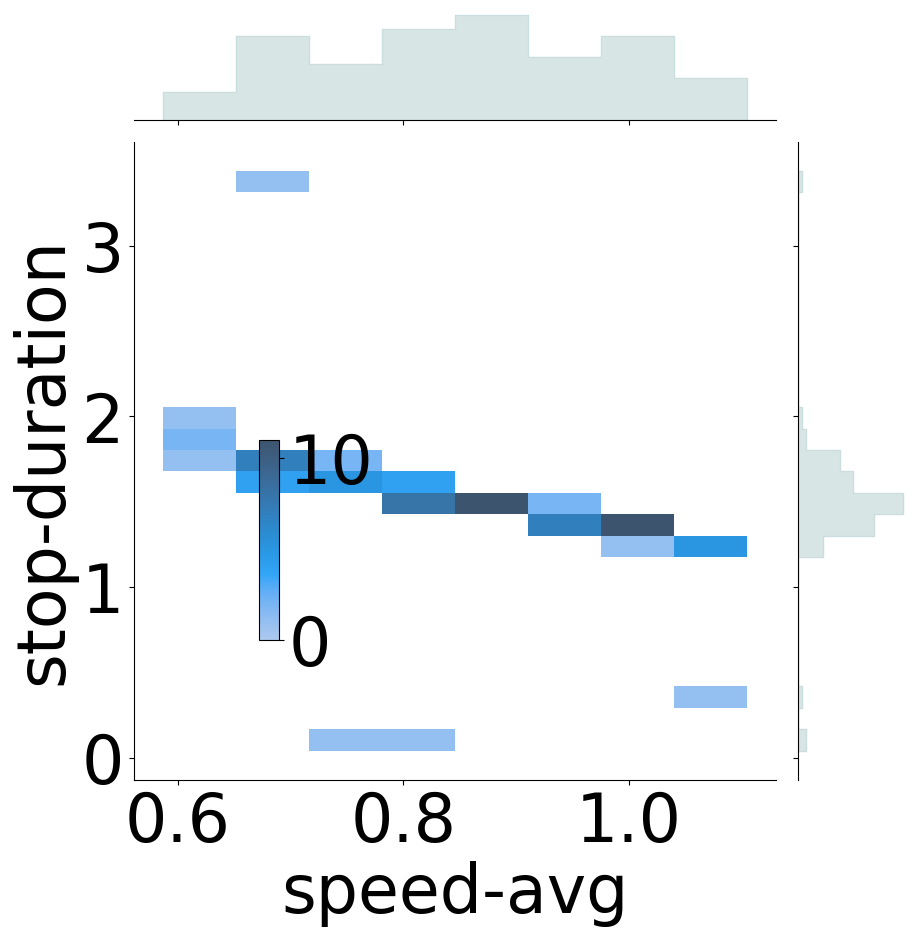

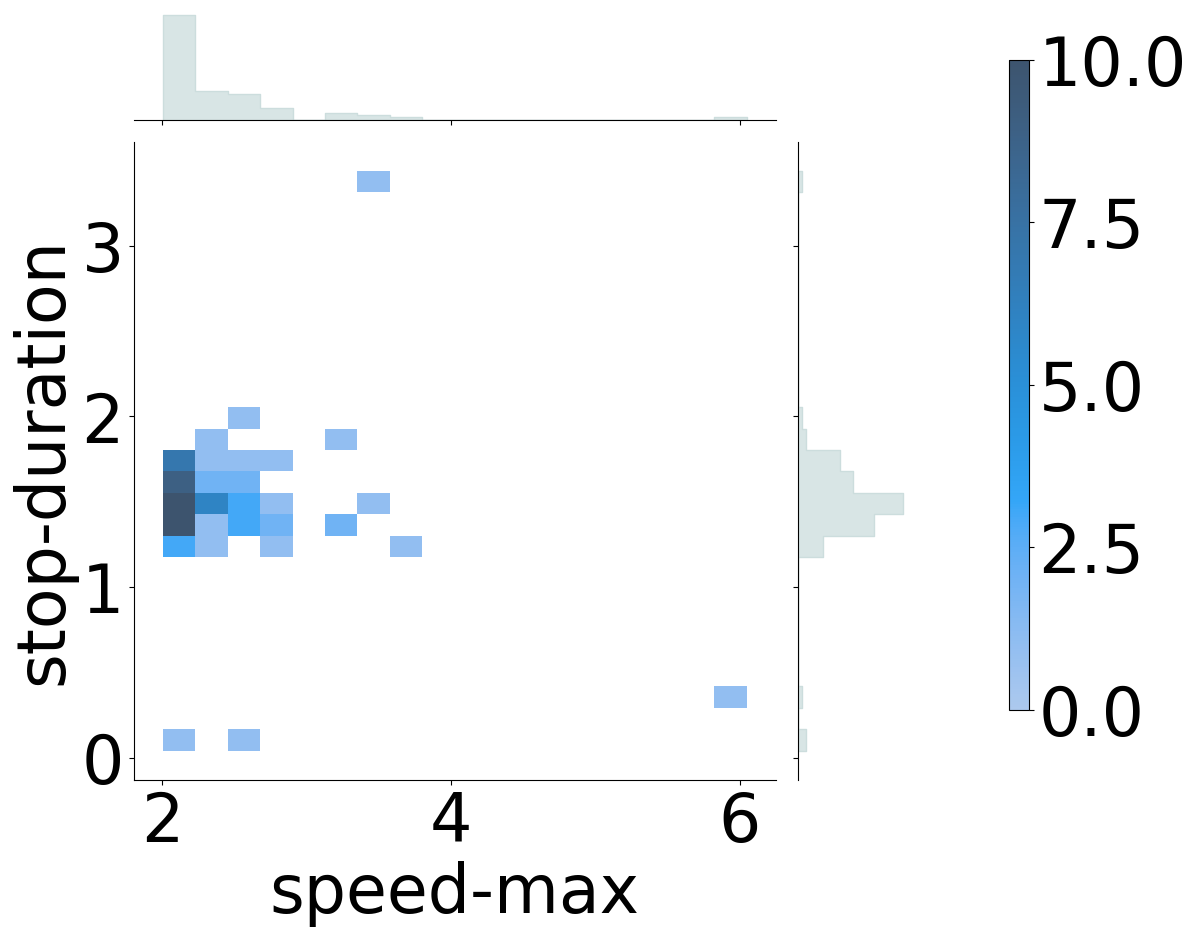

In [30]:

# g = sns.JointGrid(data=pedStats, x="speed-avg", y="stop-duration", height=10)
# # g.plot(sns.scatterplot, sns.histplot)

# cax = g.figure.add_axes([.15, .15, .02, .2])
# # Add the joint and marginal histogram plots
# j = g.plot_joint(
#     sns.histplot, discrete=(False, False),
#     cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
# )
# g.plot_marginals(sns.histplot, element="step", color="#03012d")

plotJoint(data=pedStats, x="speed-avg", y="stop-duration", height=10)
plotJoint(data=pedStats, x="speed-max", y="stop-duration", height=10, caxloc=[1.0, .18, .02, .65])


In [31]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="hist", height=10)
# ax = g.ax_joint
# cbar_ax = kdeplot.fig.add_axes([.85, .25, .05, .4])
# # plt.colorbar(ax=ax, cax=cbar_ax)
# # plt.show()
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
# print(PCM)
# plt.colorbar(PCM, ax=ax, cax=cbar_ax) 


In [32]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="kde", height=10)

In [33]:
# g = sns.jointplot(x=pedStats['speed-max'], y=pedStats['stop-duration'], kind="kde", height=10)

# Vehicle joint plots

In [34]:
# 1. create ped vehicle map

# mapping
pedToVehicle = getPedToVIds(meta)
# print(pedToVehicle)

# combine stats
# each ped row has a combination with each associated vehicle
pedCols = ['uniqueTrackId', 'stop-duration', 'speed-avg']
vehCols = ['uniqueTrackId', 'speed-avg']

newCols = ['pId', 'p-stop-duration', 'p-speed-avg', 'vId', 'v-speed-avg', 'stop-distance', 'stop-time', 'v-speed-stop']
pedIds = pedStats['uniqueTrackId'].unique()
vIds = vehicleStats['uniqueTrackId'].unique()
jointRows = []
for pedId in pedIds:
    aPed = pedStats[pedStats["uniqueTrackId"] == pedId]
    
    stopFrame = aPed.iloc[0]['stop-loc-first-frame']
    # if np.isnan(stopFrame):
    #     continue
    stopX, stopY = aPed.iloc[0]['stop-loc-first-x'], aPed.iloc[0]['stop-loc-first-y']
    
    aPed = aPed[pedCols].copy() # selection
    aPed["uniqueTrackId"] = aPed["uniqueTrackId"].astype(int)
    vIds = pedToVehicle[pedId]
    for vId in vIds:
        aV = vehicleStats[vehicleStats["uniqueTrackId"] == vId]
        aVTraj = otherDf[otherDf["uniqueTrackId"] == vId]
        
        # statistics when the pedestrian made the stop
        # print(stopFrame)
        # print(aVTraj['frame'])
        avPedStopFrameDf = aVTraj[aVTraj["frame"] == stopFrame]
        vStopX, vStopY = avPedStopFrameDf.iloc[0]['x'], avPedStopFrameDf.iloc[0]['y']
        vSpeed = avPedStopFrameDf.iloc[0]['speedSmooth']
        
        aV = aV[vehCols].copy() # selection
        aV['stop-distance'] = math.sqrt((stopX - vStopX) ** 2 + (stopY - vStopY) ** 2)
        aV['stop-time'] = stopFrame // fps
        aV['v-speed-stop'] = vSpeed
        
        aPed.reset_index(drop=True, inplace=True)
        aV.reset_index(drop=True, inplace=True)
        row = pd.concat([aPed, aV], axis=1, ignore_index=True)
        # if pedId == 35003945:
        #     print("ped", aPed)
        #     print("av", aV)
        #     print("combined", row)
        jointRows.append(row)
        
        break # get only one

# print(pedStats[pedStats["uniqueTrackId"] == 35003945])
# print(len(jointRows))
# print(jointRows)

jointStats = pd.concat(jointRows, ignore_index=True)
jointStats.columns = newCols

# print(len(pedStats), len(jointStats), len(jointStats["vId"].unique()))

assert len(pedStats) == len(jointStats)

# jointStats.describe()
# jointStats[0]
jointStats.tail()

,pId,p-stop-duration,p-speed-avg,vId,v-speed-avg,stop-distance,stop-time,v-speed-stop
74,96001632,1.32,0.993967,96001631,13.109116,5.843561,8.0,13.109037
75,97001635,1.44,0.900158,97001634,11.931835,5.869222,9.0,11.931781
76,98001638,1.80,0.640284,98001637,7.882430,4.872290,14.0,7.964281
77,99001641,1.28,1.038919,99001640,14.048599,6.081379,8.0,14.048502
78,100001644,1.36,0.954077,100001643,12.801350,5.841300,8.0,12.801322


C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


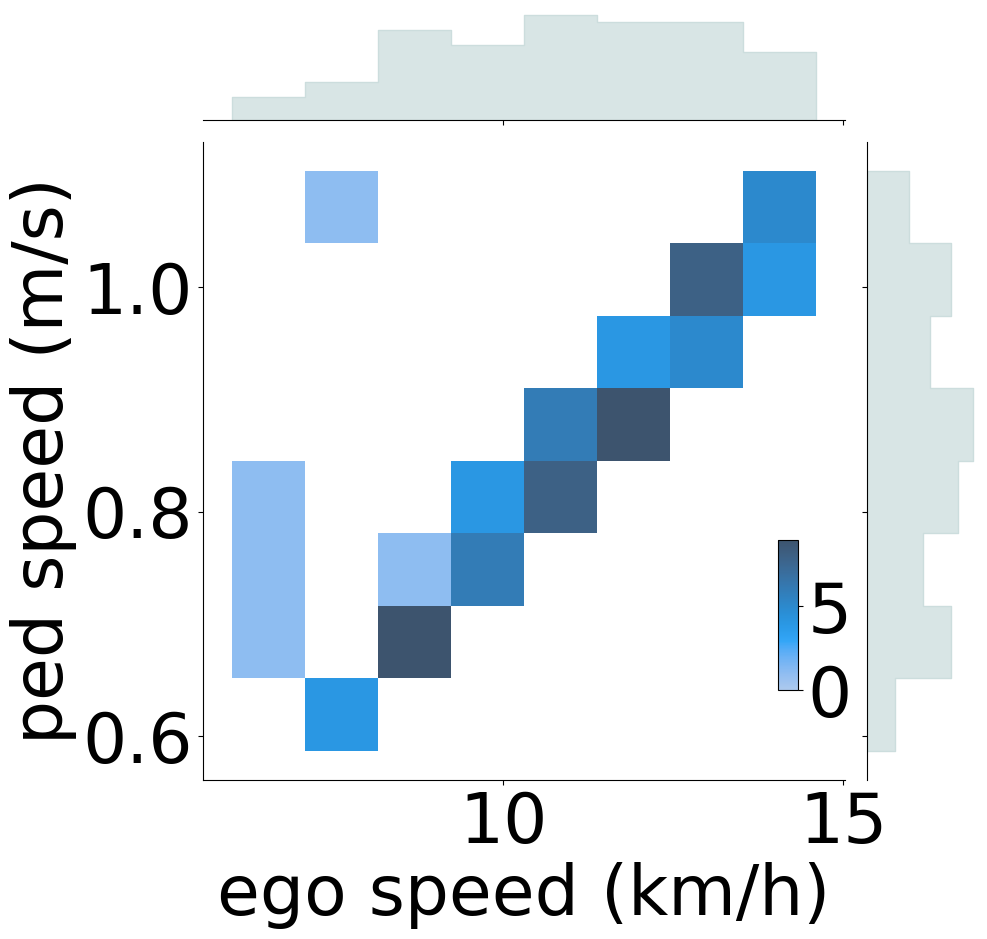

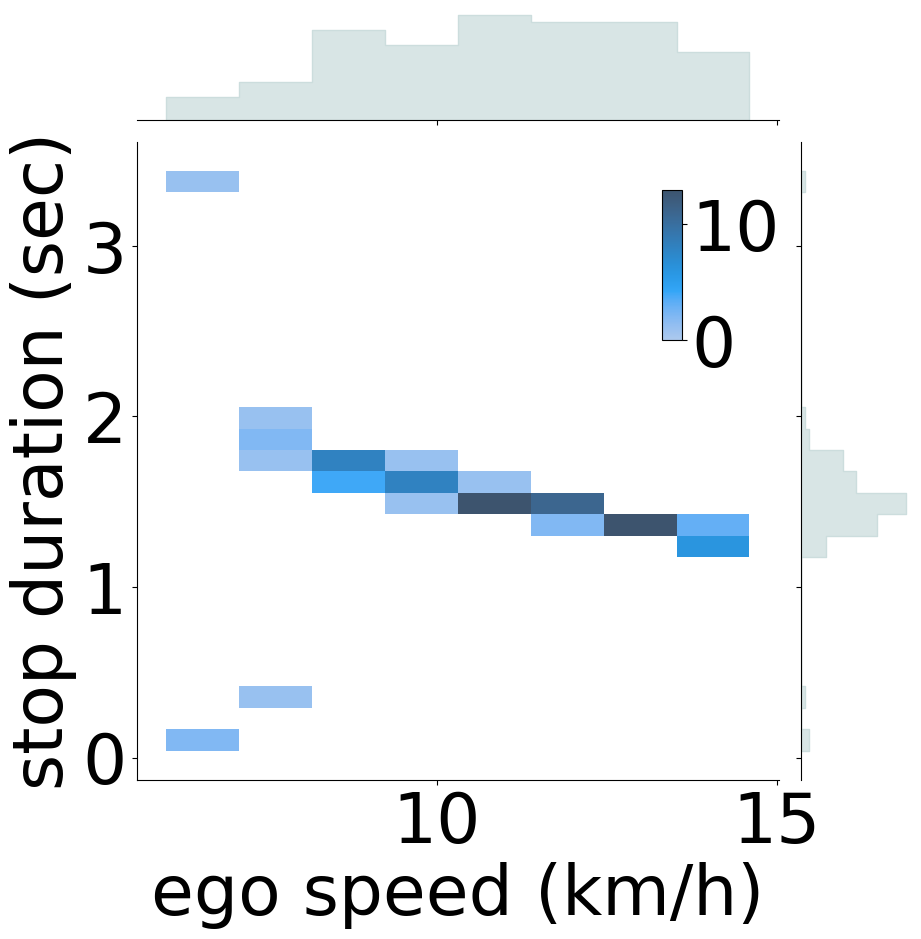

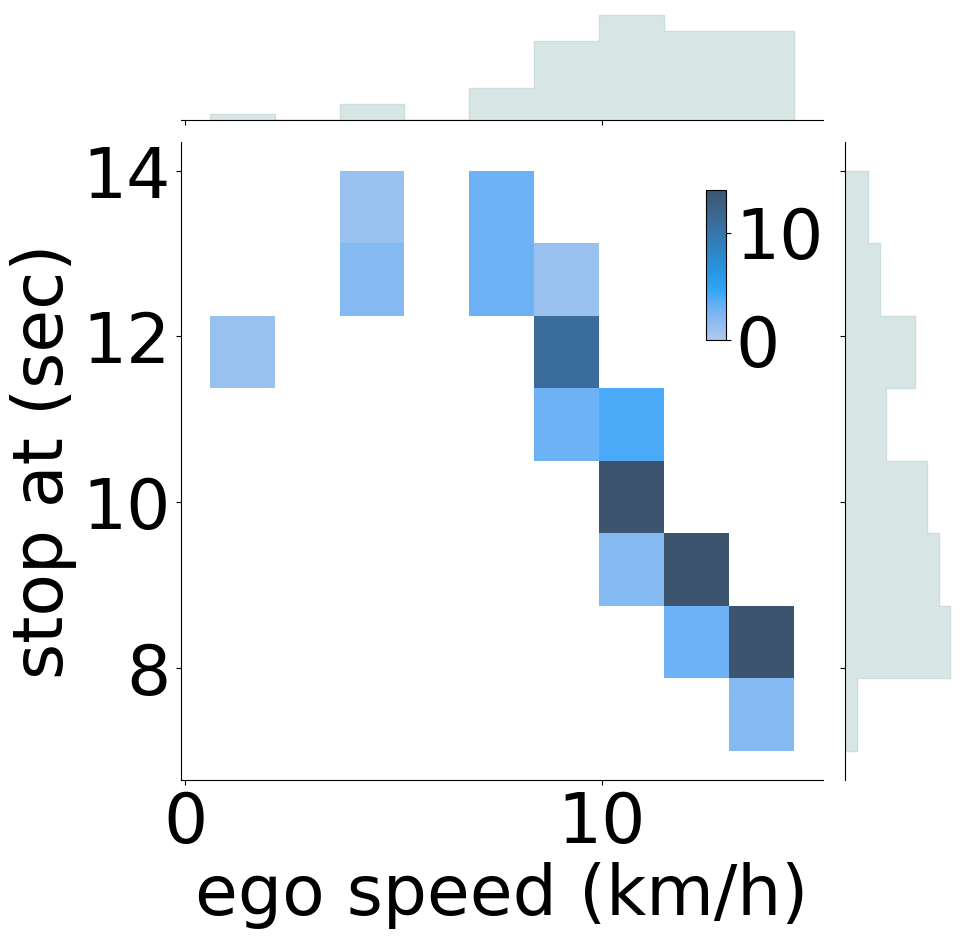

In [35]:
plt.rcParams.update({'font.size': 50})
# 2. vehicle speed vs ped speed
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="p-speed-avg", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="ped speed (m/s)",
    caxloc=[0.70, .20, 0.02, .15]
)
# 3. vehicle speed vs ped stop duration
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="p-stop-duration", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop duration (sec)",
    caxloc=[0.65, .55, 0.02, .15]
)

# 3. vehicle actual speed vs ped stop time
plotJoint(
    data=jointStats, 
    x="v-speed-stop", 
    y="stop-time", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop at (sec)",
    caxloc=[0.65, .55, 0.02, .15]
)

C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\adhocmaster\anaconda3\envs\tti\lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


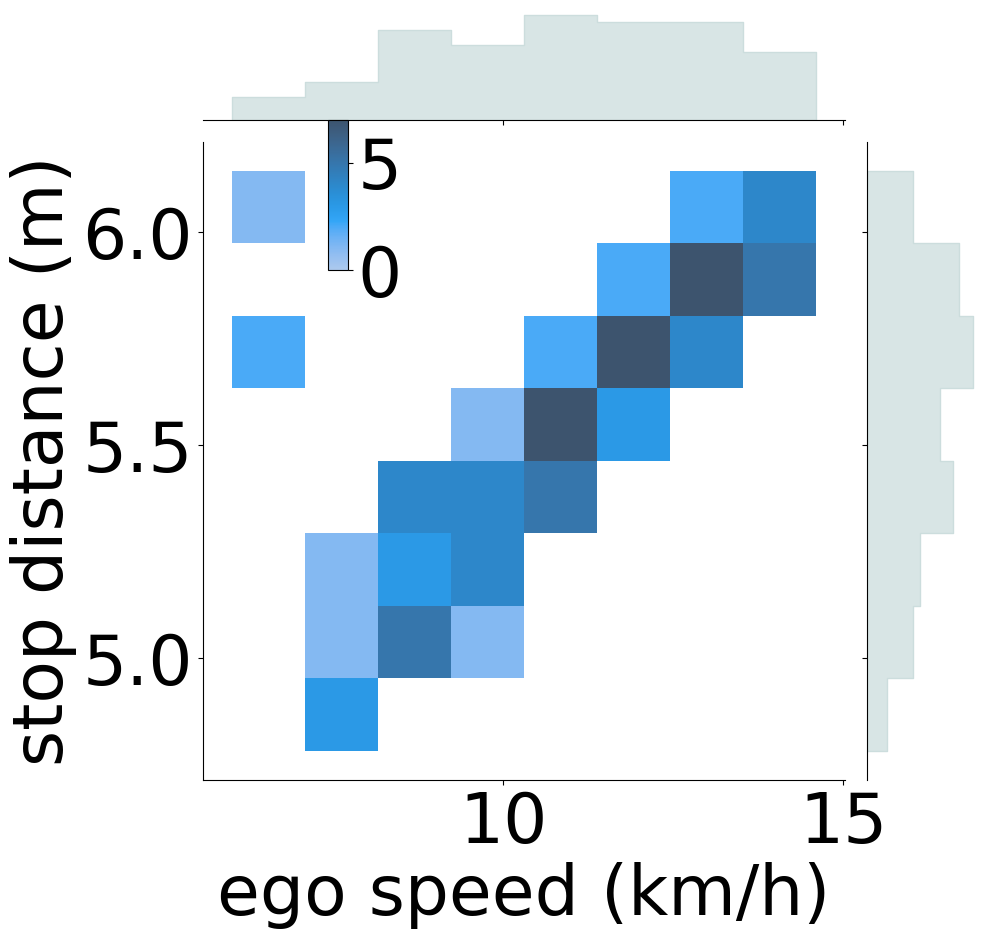

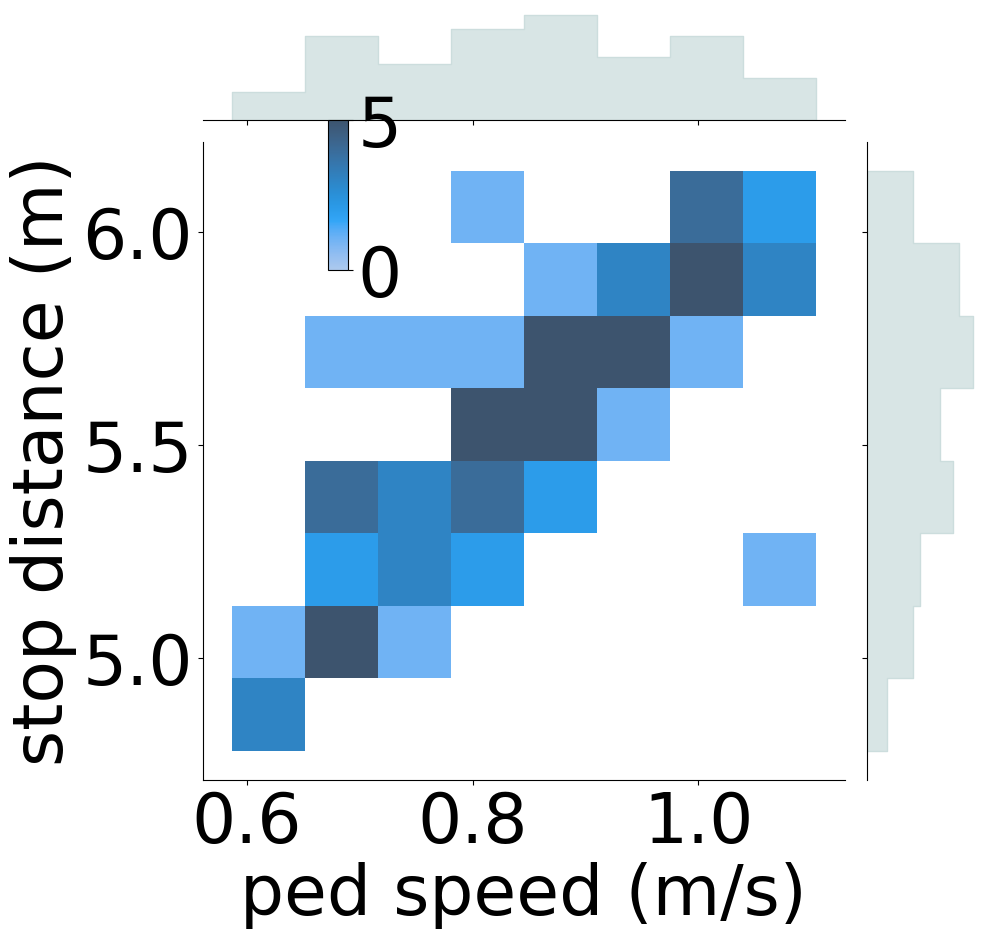

In [36]:
# 4. vehicle speed vs ped stop location
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="stop-distance", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop distance (m)",
    caxloc=[0.25, .62, 0.02, .15]
)


# 4. ped speed vs ped stop location
plotJoint(
    data=jointStats, 
    x="p-speed-avg", 
    y="stop-distance", 
    height=10, 
    xTitle="ped speed (m/s)", 
    yTitle="stop distance (m)",
    caxloc=[0.25, .62, 0.02, .15]
)

